# This is a Kaggle competition to predict housing prices
## I will be comparing which model to use: XGB, Random Forest or MLR


Lets first load required libraries:

In [25]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import pyodbc
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import SimpleRNN
from keras.datasets import imdb
from keras import initializers
from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

Lets download the dataset

In [26]:
df1 = pd.read_csv('C:/Users/taihs/OneDrive/Documents/house prices/train.csv')

In [27]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### check which categorical features to select

In [5]:
cat = df1.select_dtypes(include='object').columns

In [6]:
from scipy.stats import chi2_contingency

chi2_check = []
for i in cat:
    if chi2_contingency(pd.crosstab(df1['SalePrice'], df1[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
res = pd.DataFrame(data = [cat, chi2_check] 
             ).T 
res.columns = ['Column', 'Hypothesis']
print(res)

           Column                      Hypothesis
0        MSZoning          Reject Null Hypothesis
1          Street          Reject Null Hypothesis
2           Alley  Fail to Reject Null Hypothesis
3        LotShape          Reject Null Hypothesis
4     LandContour  Fail to Reject Null Hypothesis
5       Utilities  Fail to Reject Null Hypothesis
6       LotConfig          Reject Null Hypothesis
7       LandSlope  Fail to Reject Null Hypothesis
8    Neighborhood          Reject Null Hypothesis
9      Condition1  Fail to Reject Null Hypothesis
10     Condition2  Fail to Reject Null Hypothesis
11       BldgType  Fail to Reject Null Hypothesis
12     HouseStyle  Fail to Reject Null Hypothesis
13      RoofStyle  Fail to Reject Null Hypothesis
14       RoofMatl  Fail to Reject Null Hypothesis
15    Exterior1st  Fail to Reject Null Hypothesis
16    Exterior2nd  Fail to Reject Null Hypothesis
17     MasVnrType          Reject Null Hypothesis
18      ExterQual          Reject Null Hypothesis


In [7]:
index_names = res[ res['Hypothesis'] == 'Fail to Reject Null Hypothesis' ].index 
  
# drop these row indexes 
# from dataFrame 
res.drop(index_names, inplace = True) 
res  

,Column,Hypothesis
0,MSZoning,Reject Null Hypothesis
1,Street,Reject Null Hypothesis
3,LotShape,Reject Null Hypothesis
6,LotConfig,Reject Null Hypothesis
8,Neighborhood,Reject Null Hypothesis
17,MasVnrType,Reject Null Hypothesis
18,ExterQual,Reject Null Hypothesis
19,ExterCond,Reject Null Hypothesis
20,Foundation,Reject Null Hypothesis
21,BsmtQual,Reject Null Hypothesis


### perform one hot encoding

In [8]:
from sklearn.preprocessing import LabelEncoder
print(df1['BsmtQual'].value_counts())
lst = res['Column'].tolist()
le = LabelEncoder()
i = lst[0]
df3 = pd.DataFrame()
for i in lst:
    df1[i]=df1[i].fillna('None')
    icat=le.fit_transform(df1[i])
    df2 = pd.DataFrame({i:icat})
    df3 = pd.concat([df3,df2],axis=1)
df3.head()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64


,MSZoning,Street,LotShape,LotConfig,Neighborhood,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,Heating,CentralAir,KitchenQual,FireplaceQu,GarageFinish,GarageQual,SaleType,SaleCondition
0,3,1,3,4,5,1,2,4,2,2,4,3,1,1,2,3,2,5,8,4
1,3,1,3,2,24,2,3,4,1,2,4,1,1,1,3,5,2,5,8,4
2,3,1,0,4,5,1,2,4,2,2,4,2,1,1,2,5,2,5,8,4
3,3,1,0,0,6,2,3,4,0,4,1,3,1,1,2,2,3,5,8,0
4,3,1,0,2,15,1,2,4,2,2,4,0,1,1,2,5,2,5,8,4


In [9]:
co=df1.corr()
co['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

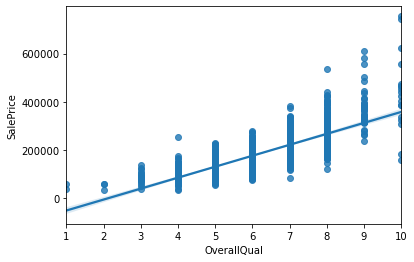

In [10]:
import seaborn as sns
sns.regplot(x=df1['OverallQual'],y=df1['SalePrice'])

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

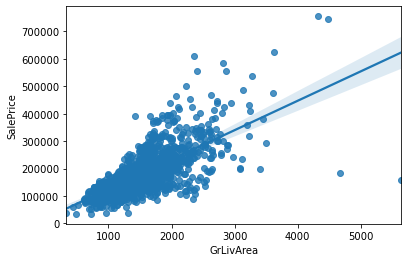

In [11]:
sns.regplot(x=df1['GrLivArea'],y=df1['SalePrice'])

In [12]:
#df = df1[['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt',\
#        'YearRemodAdd','GarageYrBlt','MasVnrArea','Fireplaces','BsmtFinSF1','LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF',\
#        'HalfBath','LotArea','BsmtFullBath','BsmtUnfSF','BedroomAbvGr','ScreenPorch','PoolArea']]
df = df1[['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt',\
        'YearRemodAdd','GarageYrBlt','MasVnrArea','Fireplaces','BsmtFinSF1','LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF']]
df.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF
0,7,1710,2,548,856,856,2,8,2003,2003,2003.0,196.0,0,706,65.0,0,854,61
1,6,1262,2,460,1262,1262,2,6,1976,1976,1976.0,0.0,1,978,80.0,298,0,0
2,7,1786,2,608,920,920,2,6,2001,2002,2001.0,162.0,1,486,68.0,0,866,42
3,7,1717,3,642,756,961,1,7,1915,1970,1998.0,0.0,1,216,60.0,0,756,35
4,8,2198,3,836,1145,1145,2,9,2000,2000,2000.0,350.0,1,655,84.0,192,1053,84


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1460 non-null   int64  
 1   GrLivArea     1460 non-null   int64  
 2   GarageCars    1460 non-null   int64  
 3   GarageArea    1460 non-null   int64  
 4   TotalBsmtSF   1460 non-null   int64  
 5   1stFlrSF      1460 non-null   int64  
 6   FullBath      1460 non-null   int64  
 7   TotRmsAbvGrd  1460 non-null   int64  
 8   YearBuilt     1460 non-null   int64  
 9   YearRemodAdd  1460 non-null   int64  
 10  GarageYrBlt   1379 non-null   float64
 11  MasVnrArea    1452 non-null   float64
 12  Fireplaces    1460 non-null   int64  
 13  BsmtFinSF1    1460 non-null   int64  
 14  LotFrontage   1201 non-null   float64
 15  WoodDeckSF    1460 non-null   int64  
 16  2ndFlrSF      1460 non-null   int64  
 17  OpenPorchSF   1460 non-null   int64  
dtypes: float64(3), int64(15)
mem

In [14]:
df = df.fillna(0)
df['GarageYrBlt']=df['GarageYrBlt'].astype('int64')
df['MasVnrArea']=df['MasVnrArea'].astype('int64')
df['LotFrontage']=df['LotFrontage'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   OverallQual   1460 non-null   int64
 1   GrLivArea     1460 non-null   int64
 2   GarageCars    1460 non-null   int64
 3   GarageArea    1460 non-null   int64
 4   TotalBsmtSF   1460 non-null   int64
 5   1stFlrSF      1460 non-null   int64
 6   FullBath      1460 non-null   int64
 7   TotRmsAbvGrd  1460 non-null   int64
 8   YearBuilt     1460 non-null   int64
 9   YearRemodAdd  1460 non-null   int64
 10  GarageYrBlt   1460 non-null   int64
 11  MasVnrArea    1460 non-null   int64
 12  Fireplaces    1460 non-null   int64
 13  BsmtFinSF1    1460 non-null   int64
 14  LotFrontage   1460 non-null   int64
 15  WoodDeckSF    1460 non-null   int64
 16  2ndFlrSF      1460 non-null   int64
 17  OpenPorchSF   1460 non-null   int64
dtypes: int64(18)
memory usage: 205.4 KB


In [15]:
X = pd.concat([df,df3],axis=1)
y = df1['SalePrice']

In [16]:
#X= preprocessing.StandardScaler().fit(X).transform(X)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

In [21]:
y_train

pandas.core.series.Series

In [18]:
Sc = preprocessing.StandardScaler()
X_train= Sc.fit(X_train).transform(X_train)
X_test= Sc.transform(X_test)

### XGB

In [73]:
xgb = XGBRegressor(n_estimators=1000)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [74]:
y_predict = xgb.predict(X_test)

In [75]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math

r2 = r2_score(y_test,y_predict)
mse = mean_squared_error(y_test,y_predict)
rmse = math.sqrt(mse)

print('r2',r2)
print('rmse',rmse)

r2 0.8620191538763274
rmse 27677.996335816144


### RandomForest

In [76]:
rf = RandomForestRegressor(n_estimators=1000)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [77]:
y_predict=rf.predict(X_test)

r2 = r2_score(y_test,y_predict)
mse = mean_squared_error(y_test,y_predict)
rmse = math.sqrt(mse)

print('r2',r2)
print('rmse',rmse)

r2 0.8904681158809774
rmse 24660.139256463706


In [78]:
rf.feature_importances_

array([5.47514129e-01, 1.22107955e-01, 2.99988098e-02, 2.00991386e-02,
       4.23717738e-02, 2.49120395e-02, 1.04932620e-02, 1.34365336e-02,
       1.18215945e-02, 9.55542599e-03, 8.74307414e-03, 8.08152879e-03,
       5.50270263e-03, 3.21789640e-02, 8.23456694e-03, 5.12616200e-03,
       4.55253388e-02, 7.14553200e-03, 3.73651277e-03, 1.96284414e-05,
       2.85635476e-03, 1.31740331e-03, 8.42225605e-03, 1.34298648e-03,
       2.20762527e-03, 9.82580889e-04, 6.78742537e-04, 8.23076717e-03,
       8.13529363e-04, 2.67771484e-03, 1.80062454e-04, 2.83008974e-03,
       3.18916890e-03, 2.03012864e-03, 2.22827345e-03, 5.51434693e-04,
       7.93368249e-04, 2.06284157e-03])

### Polynomial

In [79]:
from sklearn import linear_model

clf = linear_model.LinearRegression()
clf.fit(X_train, y_train)

LinearRegression()

In [80]:
y_predict = clf.predict(X_test)

r2 = r2_score(y_test,y_predict)
mse = mean_squared_error(y_test,y_predict)
rmse = math.sqrt(mse)

print('r2',r2)
print('rmse',rmse)

r2 0.8567095099057216
rmse 28205.508232611093


### Decision Tree

In [81]:
tree = DecisionTreeRegressor(max_depth = 8)

In [82]:
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8)

In [83]:
y_predict = tree.predict(X_test)

r2 = r2_score(y_test,y_predict)
mse = mean_squared_error(y_test,y_predict)
rmse = math.sqrt(mse)

print('r2',r2)
print('rmse',rmse)

r2 0.7875174215267675
rmse 34346.849691760166


### Load the test data

In [84]:
df1 = pd.read_csv('C:/Users/taihs/OneDrive/Documents/house prices/test.csv')

In [88]:
from sklearn.preprocessing import LabelEncoder

lst = res['Column'].tolist()
#le = LabelEncoder()

df3 = pd.DataFrame()
for i in lst:
    df1[i]=df1[i].fillna('None')
    icat=le.fit_transform(df1[i])
    df2 = pd.DataFrame({i:icat})
    df3 = pd.concat([df3,df2],axis=1)
df3.head()

,MSZoning,Street,LotShape,LotConfig,Neighborhood,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,Heating,CentralAir,KitchenQual,FireplaceQu,GarageFinish,GarageQual,SaleType,SaleCondition
0,3,1,3,4,12,2,3,4,1,4,4,3,0,1,4,3,3,4,9,4
1,4,1,0,0,12,1,3,4,1,4,4,3,0,1,2,3,3,4,9,4
2,4,1,0,4,8,2,3,4,2,2,4,3,0,1,4,5,0,4,9,4
3,4,1,0,4,8,1,3,4,2,4,4,3,0,1,2,2,0,4,9,4
4,4,1,0,4,22,2,2,4,2,2,4,3,0,1,2,3,2,4,9,4


In [89]:
#df = df1[['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt',\
#        'YearRemodAdd','GarageYrBlt','MasVnrArea','Fireplaces','BsmtFinSF1','LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF',\
#        'HalfBath','LotArea','BsmtFullBath','BsmtUnfSF','BedroomAbvGr','ScreenPorch','PoolArea']]
df = df1[['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt',\
        'YearRemodAdd','GarageYrBlt','MasVnrArea','Fireplaces','BsmtFinSF1','LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF']]
df.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF
0,5,896,1.0,730.0,882.0,896,1,5,1961,1961,1961.0,0.0,0,468.0,80.0,140,0,0
1,6,1329,1.0,312.0,1329.0,1329,1,6,1958,1958,1958.0,108.0,0,923.0,81.0,393,0,36
2,5,1629,2.0,482.0,928.0,928,2,6,1997,1998,1997.0,0.0,1,791.0,74.0,212,701,34
3,6,1604,2.0,470.0,926.0,926,2,7,1998,1998,1998.0,20.0,1,602.0,78.0,360,678,36
4,8,1280,2.0,506.0,1280.0,1280,2,5,1992,1992,1992.0,0.0,0,263.0,43.0,0,0,82


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   int64  
 1   GrLivArea     1459 non-null   int64  
 2   GarageCars    1458 non-null   float64
 3   GarageArea    1458 non-null   float64
 4   TotalBsmtSF   1458 non-null   float64
 5   1stFlrSF      1459 non-null   int64  
 6   FullBath      1459 non-null   int64  
 7   TotRmsAbvGrd  1459 non-null   int64  
 8   YearBuilt     1459 non-null   int64  
 9   YearRemodAdd  1459 non-null   int64  
 10  GarageYrBlt   1381 non-null   float64
 11  MasVnrArea    1444 non-null   float64
 12  Fireplaces    1459 non-null   int64  
 13  BsmtFinSF1    1458 non-null   float64
 14  LotFrontage   1232 non-null   float64
 15  WoodDeckSF    1459 non-null   int64  
 16  2ndFlrSF      1459 non-null   int64  
 17  OpenPorchSF   1459 non-null   int64  
dtypes: float64(7), int64(11)
mem

In [91]:
df = df.fillna(0)
df['GarageCars']=df['GarageCars'].astype('int64')
df['GarageArea']=df['GarageArea'].astype('int64')
df['TotalBsmtSF']=df['TotalBsmtSF'].astype('int64')
df['GarageYrBlt']=df['GarageYrBlt'].astype('int64')
df['MasVnrArea']=df['MasVnrArea'].astype('int64')
df['BsmtFinSF1']=df['BsmtFinSF1'].astype('int64')
df['LotFrontage']=df['LotFrontage'].astype('int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   OverallQual   1459 non-null   int64
 1   GrLivArea     1459 non-null   int64
 2   GarageCars    1459 non-null   int64
 3   GarageArea    1459 non-null   int64
 4   TotalBsmtSF   1459 non-null   int64
 5   1stFlrSF      1459 non-null   int64
 6   FullBath      1459 non-null   int64
 7   TotRmsAbvGrd  1459 non-null   int64
 8   YearBuilt     1459 non-null   int64
 9   YearRemodAdd  1459 non-null   int64
 10  GarageYrBlt   1459 non-null   int64
 11  MasVnrArea    1459 non-null   int64
 12  Fireplaces    1459 non-null   int64
 13  BsmtFinSF1    1459 non-null   int64
 14  LotFrontage   1459 non-null   int64
 15  WoodDeckSF    1459 non-null   int64
 16  2ndFlrSF      1459 non-null   int64
 17  OpenPorchSF   1459 non-null   int64
dtypes: int64(18)
memory usage: 205.3 KB


In [92]:
X = pd.concat([df,df3],axis=1)

In [93]:
X= preprocessing.StandardScaler().fit(X).transform(X)


In [94]:
y_predict_xgb = xgb.predict(X)
y_predict_rf = rf.predict(X) # best
y_predict_clf = clf.predict(X)
y_predict_tree = tree.predict(X)

In [95]:
final = pd.DataFrame({'SalePrice':y_predict_rf})

In [96]:
final1 = pd.concat([df1['Id'], final], axis=1)
final1.head()

,Id,SalePrice
0,1461,122472.858
1,1462,155646.769
2,1463,180275.441
3,1464,190108.911
4,1465,197862.168


In [97]:
final1.to_csv('sample_submission.csv', index=False)